In [23]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()


df = pd.read_csv('poetry.csv')
df = df.drop(columns=df.columns[[5, 6, 7, 8]], axis=1)

df = df[:]

def get_century_roman(year):
	century = year // 100 + 1
	roman_numerals = {
		1: 'I', 2: 'II', 3: 'III', 4: 'IV', 5: 'V',
		6: 'VI', 7: 'VII', 8: 'VIII', 9: 'IX', 10: 'X',
		11: 'XI', 12: 'XII', 13: 'XIII', 14: 'XIV', 15: 'XV',
		16: 'XVI', 17: 'XVII', 18: 'XVIII', 19: 'XIX', 20: 'XX', 21: 'XXI'
	}
	return roman_numerals[century]

def proc_row(row):	
	#text = '\n'.join(row['text'].split('\n')[:4])
	text = row['text'].replace('\r', '')

	line_count = text.count('\n') + 1
	word_count = text.count(' ') + line_count

	name = row['name'] if not pd.isna(row['name']) else row['text'].split('\n')[0] + '...'
	author = row['author'] if not pd.isna(row['author']) else 'неизвестен'

	date_from, date_to = row['date_from'], row['date_to']
	date = -1
	if not pd.isna(date_to): date = date_to
	elif not pd.isna(date_from): date = date_from

	century = ''
	epoch = ''
	if date != -1:
		century = f'{get_century_roman(date)} ({int(date//100+1)})'
		if date < 1500: epoch = 'древнерусская поэзия'
		if 1750 <= date < 1850: epoch = 'золотой век'
		if 1850 <= date < 1900: epoch = 'реализм и натурализм восемнадцатого века'
		if 1900 <= date < 1950: epoch = 'серебряный век, авангард'
		if 1950 <= date < 1990: epoch = 'советский период'
		if 1990 <= date < 2010: epoch = 'бронзовый век'
		if 2010 <= date < 2100: epoch = 'современная поэзия'


	return pd.Series({'author': author, 'name': name, 'text': text, 
				   	  'date': int(date), 'century': century, 'epoch': epoch, 
				  	  'line_count': line_count, 'word_count': word_count})

df = df.apply(proc_row, axis=1)

df.head()

,author,name,text,date,century,epoch,line_count,word_count
0,Михаил Лермонтов,Забывши волнения жизни мятежной...,"Забывши волнения жизни мятежной,\nОдин жил в п...",1829,XIX (19),золотой век,8,30
1,Сергей Есенин,"Нивы сжаты, рощи голы...","Нивы сжаты, рощи голы,\nОт воды туман и сырост...",1918,XX (20),"серебряный век, авангард",12,47
2,Игорь Северянин,ЧАРЫ ЛЮЧИНЬ,Лючинь печальная читала вечером ручьисто-вкрад...,1919,XX (20),"серебряный век, авангард",12,86
3,Анатолий Жигулин,Золото,"Глыбу кварца разбили молотом,\nИ, веселым огне...",1963,XX (20),советский период,30,123
4,Николай Тихонов,Хоровод в Сульдуси,"Хлынул дождь, когда девушки, встав в хоровод,\...",1940,XX (20),"серебряный век, авангард",16,93


In [24]:
len(df)

16694

In [16]:
from sentence_transformers import SentenceTransformer
import math

import torch
torch.cuda.empty_cache()

from tqdm import tqdm
tqdm.pandas()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2', device=device)
#model = SentenceTransformer('sentence-transformers/LaBSE', device=device)

def to_embeddings(input_text):
    tokens_count = model.tokenize(input_text)['input_ids'].shape[0]
    chunks_n = math.ceil(tokens_count / model.max_seq_length)

    step = math.ceil(len(input_text) / chunks_n)

    text_chunks = [input_text[i:i+step] for i in range(0, len(input_text), step)]
    
    embeddings = model.encode(text_chunks)
    return embeddings


Using device: cuda


In [26]:
def add_embedding_to_row(row):
	metadata = ''
	metadata += f'объем: количество строк {row["line_count"]}, '
	metadata += f'количество четверостиший: {int(row["line_count"]//4)}, '
	metadata += f'количество слов: {row["word_count"]}; '

	if row['author'] != 'неизвестен': metadata += f'автор: {row["author"]}; '

	if row['date'] != -1:
		metadata += f'временной период: {row["century"]} век, {row["date"]} год, '

	if len(row['epoch']) > 0: metadata += row['epoch'] 

	row['text_embedding'] = to_embeddings(row['name'] + '\n\n' + row['text'])
	row['metadata_embedding'] = to_embeddings(metadata)[0]

	return pd.Series(row)

df = df.progress_apply(add_embedding_to_row, axis=1)


100%|██████████| 16694/16694 [23:05<00:00, 12.05it/s]


In [27]:
df.to_pickle('poetry_data_prepared_distiluse.pkl')

In [17]:
import pandas as pd

df = pd.read_pickle('poetry_data_prepared_distiluse.pkl')
df.head()

,author,name,text,date,century,epoch,line_count,word_count,text_embedding,metadata_embedding
0,Михаил Лермонтов,Забывши волнения жизни мятежной...,"Забывши волнения жизни мятежной,\nОдин жил в п...",1829,XIX (19),золотой век,8,30,"[[-0.0060088797, 0.0023857844, -0.02221782, -0...","[0.05686018, 0.01054107, 0.0054414314, 0.00180..."
1,Сергей Есенин,"Нивы сжаты, рощи голы...","Нивы сжаты, рощи голы,\nОт воды туман и сырост...",1918,XX (20),"серебряный век, авангард",12,47,"[[-0.0103182765, -0.00081915647, -0.0445289, -...","[0.06642261, -0.015658984, -0.015394135, -0.02..."
2,Игорь Северянин,ЧАРЫ ЛЮЧИНЬ,Лючинь печальная читала вечером ручьисто-вкрад...,1919,XX (20),"серебряный век, авангард",12,86,"[[-0.015138468, -0.004268595, 0.005018465, -0....","[0.06060445, -0.03000408, -0.007322233, -0.017..."
3,Анатолий Жигулин,Золото,"Глыбу кварца разбили молотом,\nИ, веселым огне...",1963,XX (20),советский период,30,123,"[[-0.013852592, 0.009750016, 0.018812772, -0.0...","[0.059865776, 0.020784905, 0.012353897, -0.010..."
4,Николай Тихонов,Хоровод в Сульдуси,"Хлынул дождь, когда девушки, встав в хоровод,\...",1940,XX (20),"серебряный век, авангард",16,93,"[[0.014695941, 0.04887105, -0.0035296625, -0.0...","[0.057123616, -0.006725339, -0.017112186, -0.0..."


In [18]:
from transformers import pipeline
from pymorphy2 import MorphAnalyzer
import re

qa_model = pipeline("question-answering", "timpal0l/mdeberta-v3-base-squad2")

def get_normal_sentence(text, norm=True):
	morph = MorphAnalyzer()
	words = re.findall(r'\b\w+\b', text.lower())

	if not norm: return ' '.join(words)
	
	lemmatized_words = [morph.parse(word)[0].normal_form for word in words]
	
	return ' '.join(lemmatized_words)

def extract_metadata(request):
	r = qa_model(question=[
		# 'упомянутое количество строк или четверостиший или слов', 
		# 'упомянутое авторство', 
		# 'упомянутая эпоха или упомянутый век или год'
		'Какой объем?', 
		'Кто авторы или автор упомянут?', 
		'Какой век или год или эпоха?'
		], context=request) 
	
	rs = ['length', 'author', 'date']

	return {rs[i]: r[i] for i in range(len(rs))}


def to_standard(data):
	r = ''
	if data['length']['score'] > 0.02: r += f'объем: {get_normal_sentence(data['length']['answer'], norm=False)}; '
	if data['author']['score'] > 0.02: r += f'автор: {get_normal_sentence(data['author']['answer'])}; '
	if data['date']['score'] > 0.02: r += f'временной период: {get_normal_sentence(data['date']['answer'])}'
	return r


# request = 'поэзия, поэт, творчество, искусство, объемом 15 строчек, эпохи серебряного века'
request = 'сквозь ветви деревьев лучится солнце в лесу, природа, авторства Бориса Пастернака, 20 века'

print(get_normal_sentence(request))
print(extract_metadata(request))
print(to_standard(extract_metadata(request)))

сквозь ветвь дерево лучиться солнце в леса природа авторство борис пастернак 20 век
{'length': {'score': 6.185478468978545e-06, 'start': 0, 'end': 21, 'answer': 'сквозь ветви деревьев'}, 'author': {'score': 0.7630684971809387, 'start': 63, 'end': 82, 'answer': ' Бориса Пастернака,'}, 'date': {'score': 0.4827595353126526, 'start': 82, 'end': 90, 'answer': ' 20 века'}}
автор: борис пастернак; временной период: 20 век


{'length': {'score': 0.08407659083604813, 'start': 79, 'end': 95, 'answer': ' 3 четверостишья'}, 'author': {'score': 0.5271733403205872, 'start': 58, 'end': 79, 'answer': ' Владимир Маяковский,'}, 'date': {'score': 1.3570716873800848e-05, 'start': 79, 'end': 81, 'answer': ' 3'}}
объем: 3 четверостишья; автор: владимир маяковский;  
Я знаю силу слов, я знаю слов набат.
Они не те, которым рукоплещут ложи.
От слов таких срываются гроба
шагать четверкою своих дубовых ножек.
Бывает, выбросят, не напечатав, не издав,
но слово мчится, подтянув подпруги,
звенит века, и подползают поезда
лизать поэзии мозолистые руки.
Я знаю силу слов. Глядится пустяком,
опавшим лепестком под каблуками танца,
но человек душой губами костяком
. . . . . . .
(неоконченное)
{'score': 0.5737284511327744, 'text_sim': 0.2903842628002167, 'req_sim': 0.6052111387252808, 'author': 'Владимир Маяковский', 'name': 'Я знаю силу слов, я знаю слов набат...', 'date': -1, 'century': '', 'epoch': '', 'line_count': 13, 'word_count

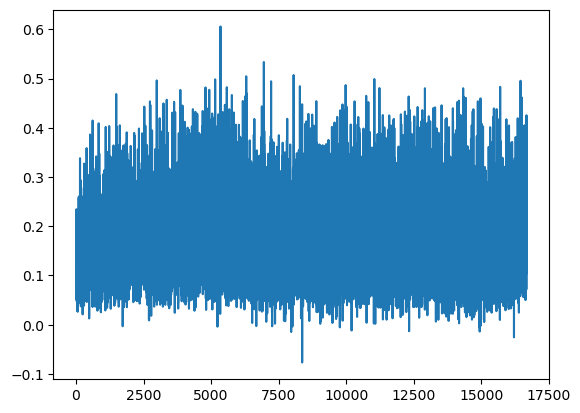

In [19]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


def cosine_similarity(a, b):
	return float(np.dot(a, b) / np.linalg.norm(a) / np.linalg.norm(b))

def best_similarity(req_emb, text_embs):
	return max(cosine_similarity(req_emb, text_emb) for text_emb in text_embs)


def search_poems(request, top_n=10, search_priority=0.1):
	mentioned_parameters = extract_metadata(request)
	standard_params_text = to_standard(mentioned_parameters) + ' '
	print(mentioned_parameters)
	print(standard_params_text)
	req_params_emb = to_embeddings(standard_params_text)[0]
	if len(standard_params_text) < 14: search_priority = 1
	
	req_emb = to_embeddings(request)[0]
	texts_datas = []

	for index, row in df.iterrows():
		text_sim = best_similarity(req_emb, row['text_embedding'])
		#text_sim = cosine_similarity(req_emb, row['text_embedding'])
		req_sim = cosine_similarity(req_params_emb, row['metadata_embedding'])
		
		score = text_sim * search_priority + req_sim * (1-search_priority)
		
		texts_datas.append({'score': score, 'text_sim': text_sim, 'req_sim': req_sim, 
			**{k: v for k, v in row.items() if k != 'metadata_embedding' and k != 'text_embedding'}})
	

	#mean_score = np.mean([x['score'] for x in texts_datas])
	#texts_datas = [x for x in texts_datas if x['score'] > mean_score * 1]
	
	texts_datas.sort(key=lambda x: x['score'])

	plt.plot([x['text_sim'] for x in sorted(texts_datas, key=lambda x: x['score'])], label='text')
	#plt.plot([x['req_sim'] for x in sorted(texts_datas, key=lambda x: x['score'])], label='req')

	return texts_datas[-top_n:][::-1]


#request = 'из окны видны грустные пожелтевшие деревья но все же это моя любимая романтика'
#request = 'научный энтузиазм и борение за оригинальную идею'
#request = 'поднять! сделать! решительность! я! восклецания'
#request = 'дыр бул щыл убеш щур скум вы со бу р л эз'
#request = 'стихотворение, поэзия, поэт, творчество, искусство'
#request = 'деревня родная природа луги поля и просторы'
request = 'стихотворение, поэзия, поэт, творчество, искусство, Автор: Владимир Маяковский, 3 четверостишья'
#request = 'солнце плещет сквозь ветви дерева'
#request = 'Автор: Александр Крученых'
# request = 'снова я напиваюсь'
#request = 'О стихах и поэте, авторство Бориса Пастернака'
#request = 'одиночество, когда теряет равновесие твое сознание усталое, одиночество, автор: Иосиф Бродский'

finded = search_poems(request)

for d in finded:
	print(d['text'])
	print({k: v for k, v in d.items() if k != 'text'})
	print('------')

In [20]:
print(cosine_similarity(to_embeddings('В поэзии - пора эстрады, Ее ликующий парад.'), to_embeddings('поэзия и поэт')))
print(cosine_similarity(to_embeddings('Страшней, чем горе, эта скука.'), to_embeddings('поэзия и поэт')))
print(cosine_similarity(to_embeddings('Пронизан солнцем лес насквозь. Лучи стоят столбами пыли.'), to_embeddings('поэзия и поэт')))

ValueError: shapes (1,512) and (1,512) not aligned: 512 (dim 1) != 1 (dim 0)